In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
# Global Variables

N = 512 # Image Size
G = 32 # Watermark Size
P = 42 # Max Moment

# Steps

T_STEP = int(P / 10) + 1
I_STEP = int(N / 20) + 1

In [28]:
%run -i ./ownlib/PHT-Library.ipynb
%run -i ./ownlib/RIW-Library.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

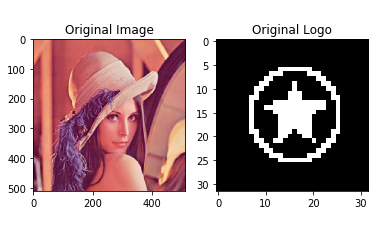

In [4]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/converse.png', 0)

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (N, N)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (G,G))
LOGO = (LOGO >= 128) * 1

# Show Image and Logo
imgshow([[IMG_BGR, LOGO]], [['Original Image', 'Original Logo']])

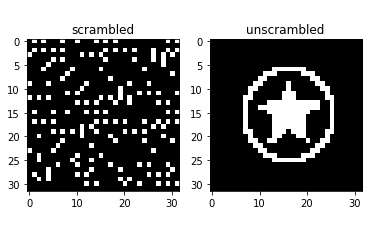

In [5]:
logo_sc = scramble(LOGO)
logo_usc = unscramble(logo_sc)
imgshow([[logo_sc, logo_usc]], [['scrambled', 'unscrambled']])

Progress: [####################] 100.0%


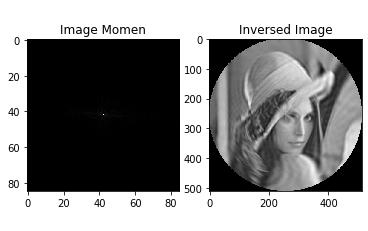

In [6]:
# Calculate Momen of Original Image
MOMEN = transformPHT(IMG_Y, N, P)
IMG_Y_INV = inversePHT(MOMEN, N, P)
imgshow([[MOMEN, IMG_Y_INV]], [['Image Momen', 'Inversed Image']])

Progress: [####################] 100.0%
2624


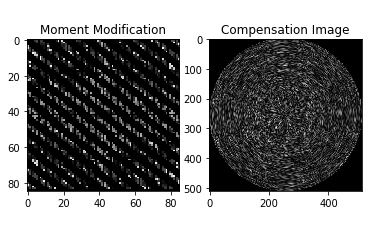

In [7]:
# Calculate Embedded Momen

# Watermarking Power
DELTA = 0.2

# Current Binary Value
matQ = np.floor(np.abs(MOMEN) / DELTA) % 2

# Set Watermark Position
P2 = P * 2 + 1

# Calculate Watermark Matrix
(doubleLogo, doubleFilter, maxIndex) = watermarkEmbed(LOGO, P)
        
# Modified Momen
XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / DELTA) * DELTA

OMEGA = - XI
OMEGA = OMEGA + DELTA / 2 * (matQ == doubleLogo)
OMEGA = OMEGA + 3 * DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_or(XI > DELTA / 2, np.abs(MOMEN) < DELTA))
OMEGA = OMEGA - DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_and(XI <= DELTA / 2, np.abs(MOMEN) >= DELTA))

OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
OMEGA = OMEGA * doubleFilter

# Calculate Compensation Image
EPSILON = inversePHT(OMEGA, N, P)
# EPSILON = OMEGA

# Show Modified Momen
imgshow([[OMEGA, EPSILON]], [['Moment Modification', 'Compensation Image']])
print(maxIndex)

In [8]:
print(np.max(OMEGA))
print(np.min(OMEGA))

(0.2611958782333806+0.03383372655094987j)
(-0.28575947027240234-0.07103073853976674j)


In [9]:
print(np.max(EPSILON))
print(np.min(EPSILON))

(21.649952862796802-3.5457747848965937e-15j)
(-21.353324866218266+1.3877787807814457e-16j)


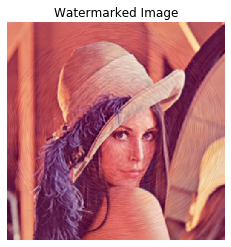

In [10]:
# Add Compensation Image to Original Image
# IMG_Y_WATERMARKED = IMG_Y + (EPSILON - np.min(IMG_Y_INV)) / (np.max(IMG_Y_INV) - np.min(IMG_Y_INV)) * 255
IMG_Y_WATERMARKED = IMG_Y + EPSILON

# Add Original Image back to YCRCB scheme
IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)

imgshow1(IMG_WATERMARKED, 'Watermarked Image')

In [11]:
img_dist = (IMG_WATERMARKED - IMG_BGR)
img_dist = img_dist * img_dist
MSE = np.sum(img_dist) / (9 * N * N)
PSNR = 10 * np.log10(255 * 255 / MSE)

print('MSE = {}'.format(MSE))
print('PSNR = {}dB'.format(PSNR))

MSE = 6.496837615966797
PSNR = 40.003783488617984dB


In [12]:
# Modified function
def attackAndDisplay(image, title, isNeedAntiTranslation=False):
    processAndDisplayAttack(image, IMG_WATERMARKED, title, LOGO, P, G, DELTA, isNeedAntiTranslation)

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


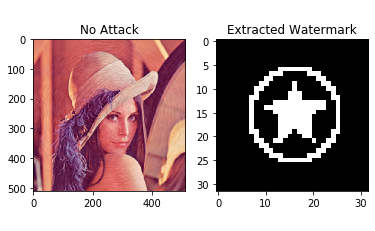

In [13]:
attackAndDisplay(IMG_WATERMARKED, 'No Attack')

Progress: [####################] 100.0%
BE  :  4.0
BER :  0.39%
Inverse Translation X=0 Y=0


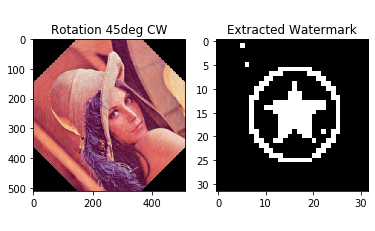

In [14]:
# Attack: Rotation 30 degree
ROTATION_ANGLE = 45
IMG_ROTATE = attackRotation(IMG_WATERMARKED, ROTATION_ANGLE)
attackAndDisplay(IMG_ROTATE, 'Rotation {}deg CW'.format(ROTATION_ANGLE), True)

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


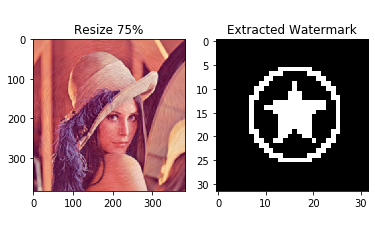

In [15]:
# Attack: Resize 75%
RESIZE_FACTOR = 0.75
IMG_RESIZE = attackResize(IMG_WATERMARKED, int(RESIZE_FACTOR * N))
attackAndDisplay(IMG_RESIZE, 'Resize ' + '{:.0%}'.format(RESIZE_FACTOR))

Progress: [####################] 100.0%
BE  :  91.0
BER :  8.89%
Inverse Translation X=-15 Y=13


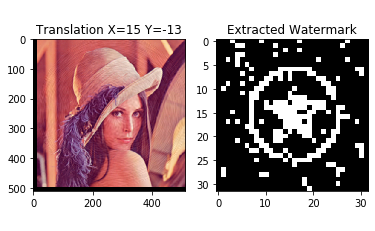

In [16]:
# Attack: Translation By Pixel

TRANSLATION_X_PIXEL = 15
TRANSLATION_Y_PIXEL = -13

IMG_TRANSLATE2 = attackTranslateByPixel(IMG_WATERMARKED, TRANSLATION_X_PIXEL, TRANSLATION_Y_PIXEL)
attackAndDisplay(IMG_TRANSLATE2, 'Translation X={} Y={}'.format(TRANSLATION_X_PIXEL, TRANSLATION_Y_PIXEL), True)

Progress: [####################] 100.0%
BE  :  105.0
BER :  10.25%
Inverse Translation X=-25 Y=25


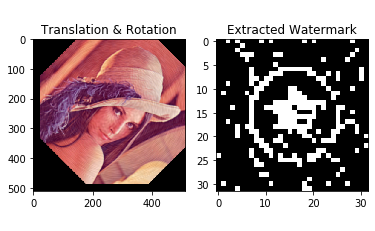

In [17]:
# Attack: Translation

TRANSLATION_X_PERCENTAGE = 0.05
TRANSLATION_Y_PERCENTAGE = -0.05

IMG_TRANSLATE = attackRotation(IMG_WATERMARKED, -45)
IMG_TRANSLATE = attackTranslate(IMG_TRANSLATE, TRANSLATION_X_PERCENTAGE, TRANSLATION_Y_PERCENTAGE)
attackAndDisplay(IMG_TRANSLATE, 'Translation & Rotation', True)

Progress: [####################] 100.0%
BE  :  70.0
BER :  6.84%


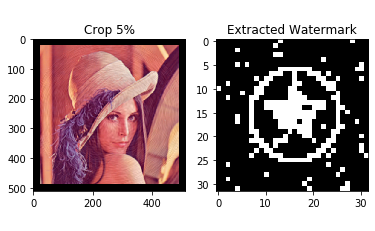

In [18]:
# Attack: FRAME 5%
CROP_PERCENTAGE = 0.05

IMG_CROP = attackCrop(IMG_WATERMARKED, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
attackAndDisplay(IMG_CROP, 'Crop ' + '{:.0%}'.format(CROP_PERCENTAGE))

Progress: [####################] 100.0%
BE  :  26.0
BER :  2.54%


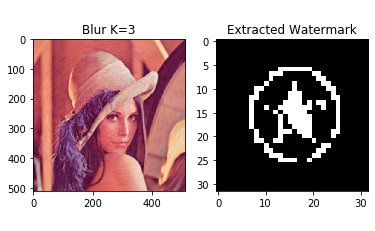

In [19]:
# Attack: BLUR 3x3
BLUR_KERNEL_SIZE = 3

IMG_BLUR = attackBlur(IMG_WATERMARKED, BLUR_KERNEL_SIZE)
attackAndDisplay(IMG_BLUR, 'Blur K={}'.format(BLUR_KERNEL_SIZE))

Progress: [####################] 100.0%
BE  :  54.0
BER :  5.27%


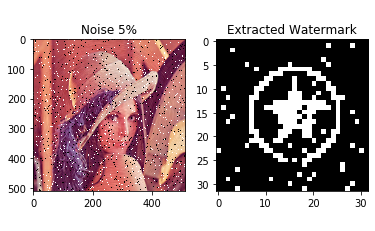

In [20]:
# Attack: RANDOM NOISE 3%

NOISE_PERCENTAGE = 0.05
IMG_NOISE = attackRandomNoise(IMG_WATERMARKED, NOISE_PERCENTAGE)
attackAndDisplay(IMG_NOISE, 'Noise ' + '{:.0%}'.format(NOISE_PERCENTAGE))

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


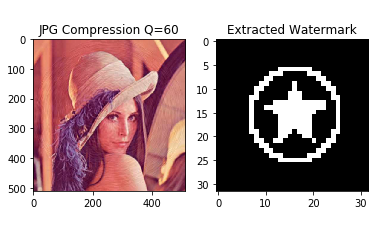

In [21]:
# Attack: JPG Compression
COMPRESSION_QUALITY = 60
IMG_JPG = attackJPG(IMG_WATERMARKED, ROTATION_ANGLE)
attackAndDisplay(IMG_JPG, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY), False)

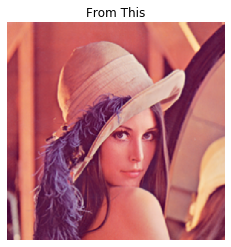

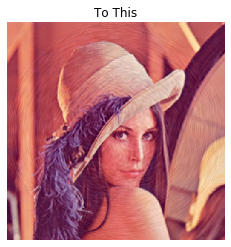

In [29]:
imsave(IMG_BGR, 'original', 'From This')
imsave(IMG_WATERMARKED, 'watermarked', 'To This')